# Подготовительный этап

Установка торча, и PyG. 

In [ ]:
import torch

print(torch.__version__)

: 

In [1]:
pip install torch_geometric

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.1 MB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 456 kB 51.5 MB/s eta 0:00:01
     |████████████████████████████████| 46 kB 7.1 MB/s eta 0:00:011
     |████████████████████████████████| 92 kB 5.2 MB/s  eta 0:00:01
     |████████████████████████████████| 63 kB 10.0 MB/s eta 0:00:01
     |████████████████████████████████| 52 kB 5.7 MB/s  eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.5.0+cpu.html

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/torch-2.5.0+cpu.html
     |████████████████████████████████| 1.5 MB 312 kB/s eta 0:00:01
     |████████████████████████████████| 643 kB 336 kB/s eta 0:00:01
     |████████████████████████████████| 588 kB 307 kB/s eta 0:00:01
     |████████████████████████████████| 619 kB 353 kB/s eta 0:00:01
     |████████████████████████████████| 261 kB 353 kB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Для предотвращения ошибок:

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [4]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# Скачиваем датасет и проводим анализ

В качестве примера был взят датасет Cora, который представляет собой начную цитатную сеть, где узлы (nodes) - научные работы, рёбра (edges) - это ссылки (цитирования) между статьями, признаки (features) - bag of words из 1433 уникальных слов. Каждая статья принадлежит к одной из 7 тематических категорий (label), необходимо как раз предсказать по BoW какой label у статьи (то есть какая категория).

In [5]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

/Users/master/Library/Python/3.9/lib/python/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/Users/master/Library/Python/3.9/lib/python/site-packages/libpyg.so, 0x0006): Library not loaded: /Library/Frameworks/Python.framework/Versions/3.9/Python
  Referenced from: <629B943E-D239-3C78-B7A6-C13CE3403D89> /Users/master/Library/Python/3.9/lib/python/site-packages/libpyg.so
  Reason: tried: '/Library/Frameworks/Python.framework/Versions/3.9/Python' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/Python.framework/Versions/3.9/Python' (no such file), '/Library/Frameworks/Python.framework/Versions/3.9/Python' (no such file)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/Users/master/Library/Python/3.9/lib/python/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen

In [6]:
len(dataset)

1

Данный датасет содержит только один граф, рассмотрим его 

In [7]:
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

`x=[2708, 1433]` представляет собой Node feature matrix, то есть она описывает особенности узлов. Первая величина характеризует общее количество узлов, а вторая величина - количество признаков у одного узла.
`edge_index=[2, 10556]` описывает собой рёбра графов в COO формате. В этом формате в первой строке содержатся узлы из которых идёт связь, а под ними, во второй строке, номер узла в который эта связь заходит. Таким образом общее количество связей в данном графе - 10556.
`y=[2708]` описывает метку класса этих узлов.
`train_mask=[2708], val_mask=[2708], test_mask=[2708]` описывают какие узлы используются для обучения, валидации и теста соответственно. Если их рассмотреть то там будут булевые значения 0/1. Соответственно 0 - данный узел не используется в соотв. маске, 1 - используется. Рассмотрим, в какой пропорции разделены эти данные:

In [8]:
print(f'В train находится {data.train_mask.sum().item()} образцов;')
print(f'В val находится {data.val_mask.sum().item()} образцов;')
print(f'В test находится {data.test_mask.sum().item()} образцов;')


В train находится 140 образцов;
В val находится 500 образцов;
В test находится 1000 образцов;


Рассмотрим признаки первой статьи:

In [9]:
print(data.x[0].sum().item()) 

9.0


Всего 9 слов из 1433 были замечены в данной статье.

In [10]:
# Соберём небольшу информацию о графе
print(f'Количество узлов: {data.num_nodes}')
print(f'Количество связей: {data.num_edges}')
print(f'Среднее количество связей у одного узла: {data.num_edges / data.num_nodes:.2f}')
print(f'Количество узлов для обучения: {data.train_mask.sum()}')
print(f'Доля узлов для обучения: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Есть изолированные узлы: {data.has_isolated_nodes()}')
print(f'Есть циклы: {data.has_self_loops()}')
print(f'Граф направленный: {data.is_directed()}')
print(f'Граф сжатый: {data.is_coalesced()}')

Количество узлов: 2708
Количество связей: 10556
Среднее количество связей у одного узла: 3.90
Количество узлов для обучения: 140
Доля узлов для обучения: 0.05
Есть изолированные узлы: False
Есть циклы: False
Граф направленный: False
Граф сжатый: False


In [10]:
print(data.edge_index.t())

tensor([[ 633,    0],
        [1862,    0],
        [2582,    0],
        ...,
        [ 598, 2707],
        [1473, 2707],
        [2706, 2707]])


Как видно, ребра описываются парой чисел, где первое характеризует узел из которого идёт ребро, а второе число - узел, в который это ребро заходит. Это и есть COO формат и он часто используется для описания разреженных (sparce) матриц, т.е. таких матриц, где много элементов равны 0.

Для отображения графа визуаьлно перейдём в формат `networkx` библиотеки:

edges: 10556


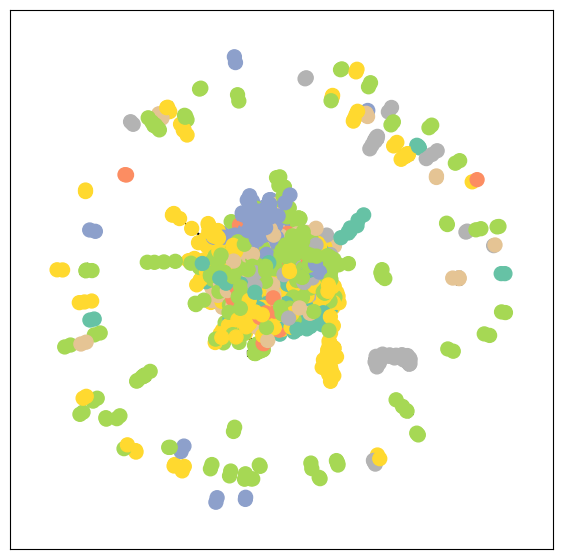

In [ ]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

Почему-то не получается никак отобразить рёбра на графе.

# Создание baseline: MLP

В теории, мы должны суметь определить категорию научной работы базируясь исключительно на её содержании, т.е. bag-of-words. Проверим это, создав MLP, которая работает только с признаками входных узлов. То есть, каждый узел представляет собой набор слов, и сеть будет использовать общие веса для всех узлов, что означает, что она будет рассматривать набор слов в общем, игнорируя взаимосвязи между научными работами.

Иными словами, проверяем, можно ли достичь хорошей классификации темы научных работ только на основе их представления, без учёта ссылок работ друг на друга (графов).

In [19]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


В данной модели MLP существует два линейных слоя, между которыми стоит ReLU, а также dropout. Сначала преобразуется 1433-размерные фичи в 16-размерный эмбеддинг, а второй слой выступает уже в роли классификатора и должен сопоставить каждому низкоразмерному эмбеддингу один из 7 классов. 

Обучим данную модель с использованием cross-entropy loss и Adam optimizer. Также определим тестовую функцию, которая будет оценивать как хорошо наш классификатор справляется на тестовом наборе, т.е. на том наборе, который не использовался во время обучения.

In [20]:
model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # лосс - cross entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # optimizer - Adam

def train():
      model.train()
      optimizer.zero_grad()  # Очищаем градиенты
      out = model(data.x)  # Делаем один шаг
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Рассчитываем loss
      loss.backward()  # Считаем градиенты
      optimizer.step()  # Обновляем параметры в зависимости от градиентов
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Используем в качестве предсказания класс с максимальной величиной вероятности
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # здесь выводим true (1) если правильно угадали
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # считаем долю правильных предсказаний
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9589
Epoch: 002, Loss: 1.9115
Epoch: 003, Loss: 1.8296
Epoch: 004, Loss: 1.7399
Epoch: 005, Loss: 1.6110
Epoch: 006, Loss: 1.5677
Epoch: 007, Loss: 1.4014
Epoch: 008, Loss: 1.3110
Epoch: 009, Loss: 1.2361
Epoch: 010, Loss: 1.1290
Epoch: 011, Loss: 1.0854
Epoch: 012, Loss: 0.9861
Epoch: 013, Loss: 0.8618
Epoch: 014, Loss: 0.8257
Epoch: 015, Loss: 0.6789
Epoch: 016, Loss: 0.7199
Epoch: 017, Loss: 0.6508
Epoch: 018, Loss: 0.6374
Epoch: 019, Loss: 0.5672
Epoch: 020, Loss: 0.4760
Epoch: 021, Loss: 0.4683
Epoch: 022, Loss: 0.4964
Epoch: 023, Loss: 0.4768
Epoch: 024, Loss: 0.4000
Epoch: 025, Loss: 0.4318
Epoch: 026, Loss: 0.4132
Epoch: 027, Loss: 0.3652
Epoch: 028, Loss: 0.3459
Epoch: 029, Loss: 0.3336
Epoch: 030, Loss: 0.2924
Epoch: 031, Loss: 0.3015
Epoch: 032, Loss: 0.3098
Epoch: 033, Loss: 0.2611
Epoch: 034, Loss: 0.3010
Epoch: 035, Loss: 0.3030
Epoch: 036, Loss: 0.2753
Epoch: 037, Loss: 0.2880
Epoch: 038, Loss: 0.2475
Epoch: 039, Loss: 0.3480
Epoch: 040, Loss: 0.2840


После этого можем оценить качество модели на тестовом наборе:

In [21]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.2f}')

Test Accuracy: 0.57


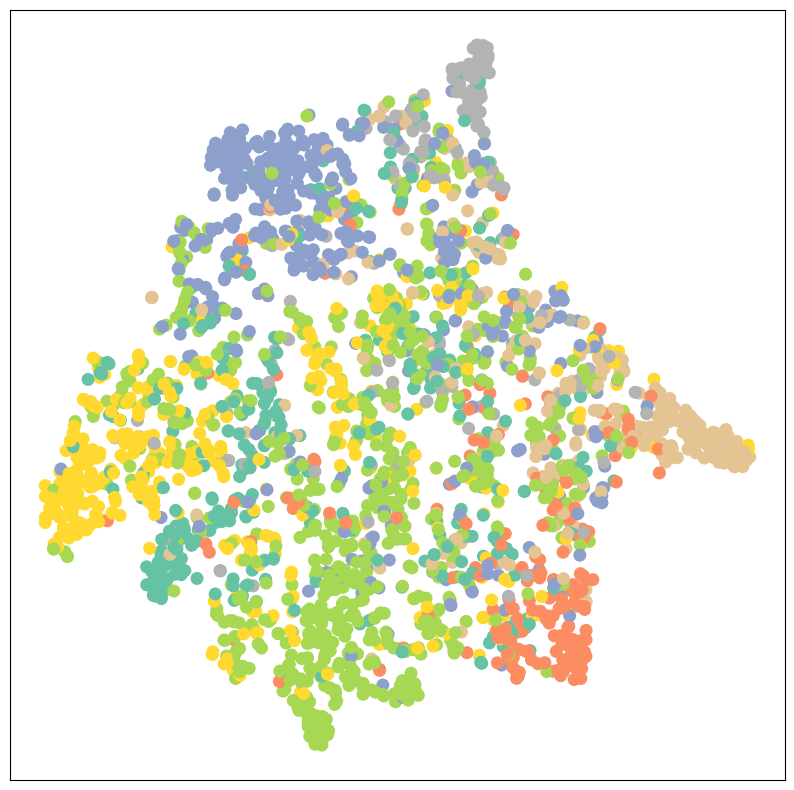

In [23]:
model.eval()

out = model(data.x)
visualize(out, color=data.y)

Как видно, точность составила всего 57%. Основная причина столь плохого поведения это то, что MLP переобучается, поскольку имеет доступ лишь к небольшому количеству узлов. Таким образом модель имеет плохую обобщающую способность.

Также не учитывается важная предоставленная нам информация: статьи, которые цитируются в работе, могут много сообщить о теме данной работы. Именно эту информацию позволяют учитывать графовые нейронные сети.

# Обучение графовой нейронной сети

Можно легко трансформировать нашу бейзлайн модель (MLP) в графовую заменив Linear слои на GCN.

В ходе данной работы используется модель пространственной (spatial) парадигмы, а именно сети с использованием GCN. Данная парадигма основывается на алгоритме передаче сообщений: 

![message_passing](message_passing.svg)

In [ ]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


Визуализируем векторные представления узлов (embedding) в необученной GCN. Для визуализация используется TSNE, чтобы отобразить 7-мерные векторы на 2д плоскости.

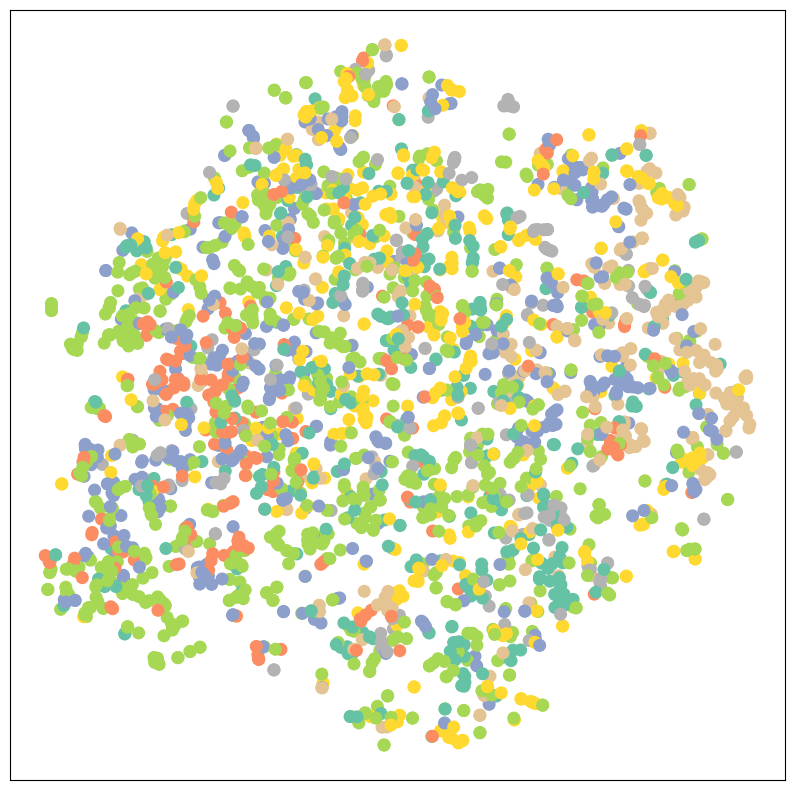

In [15]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

Обучим GCN также как MLP, но в этот раз будем передавать ей ещё информацию о рёбрах (edge_index):

In [16]:
model = GCN(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # лосс - cross entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # optimizer - Adam

def train():
      model.train()
      optimizer.zero_grad()  # Очищаем градиенты
      out = model(data.x, data.edge_index)  # Делаем один шаг
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Рассчитываем loss
      loss.backward()  # Считаем градиенты
      optimizer.step()  # Обновляем параметры в зависимости от градиентов
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Используем в качестве предсказания класс с максимальной величиной вероятности
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # здесь выводим true (1) если правильно угадали
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # считаем долю правильных предсказаний
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9523
Epoch: 002, Loss: 1.8623
Epoch: 003, Loss: 1.7444
Epoch: 004, Loss: 1.6160
Epoch: 005, Loss: 1.4674
Epoch: 006, Loss: 1.3654
Epoch: 007, Loss: 1.2469
Epoch: 008, Loss: 1.1128
Epoch: 009, Loss: 0.9917
Epoch: 010, Loss: 0.8651
Epoch: 011, Loss: 0.7830
Epoch: 012, Loss: 0.7212
Epoch: 013, Loss: 0.6193
Epoch: 014, Loss: 0.5478
Epoch: 015, Loss: 0.5029
Epoch: 016, Loss: 0.4430
Epoch: 017, Loss: 0.3946
Epoch: 018, Loss: 0.3410
Epoch: 019, Loss: 0.3056
Epoch: 020, Loss: 0.2745
Epoch: 021, Loss: 0.2727
Epoch: 022, Loss: 0.2354
Epoch: 023, Loss: 0.2047
Epoch: 024, Loss: 0.1939
Epoch: 025, Loss: 0.1491
Epoch: 026, Loss: 0.1828
Epoch: 027, Loss: 0.1721
Epoch: 028, Loss: 0.1270
Epoch: 029, Loss: 0.1265
Epoch: 030, Loss: 0.1228
Epoch: 031, Loss: 0.1113
Epoch: 032, Loss: 0.0913
Epoch: 033, Loss: 0.0993
Epoch: 034, Loss: 0.1178
Epoch: 035, Loss: 0.0816
Epoch: 036, Loss: 0.0915
Epoch: 037, Loss: 0.0968
Epoch: 038, Loss: 0.0722
Epoch: 039, Loss: 0.0550
Epoch: 040, Loss: 0.0717


Оценим точность предсказаний на тестовом наборе:

In [17]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.2f}')

Test Accuracy: 0.80


Получили точность 80%, что намного выше, чем у MLP. Это означает, что догадка оказалась верной - взяв во внимание цитируемые статьи получилось определить тему работы намного точнее.

Подтвердить это также возможно вновь взглянув на векторные представления узлов в уже обученной GCN.

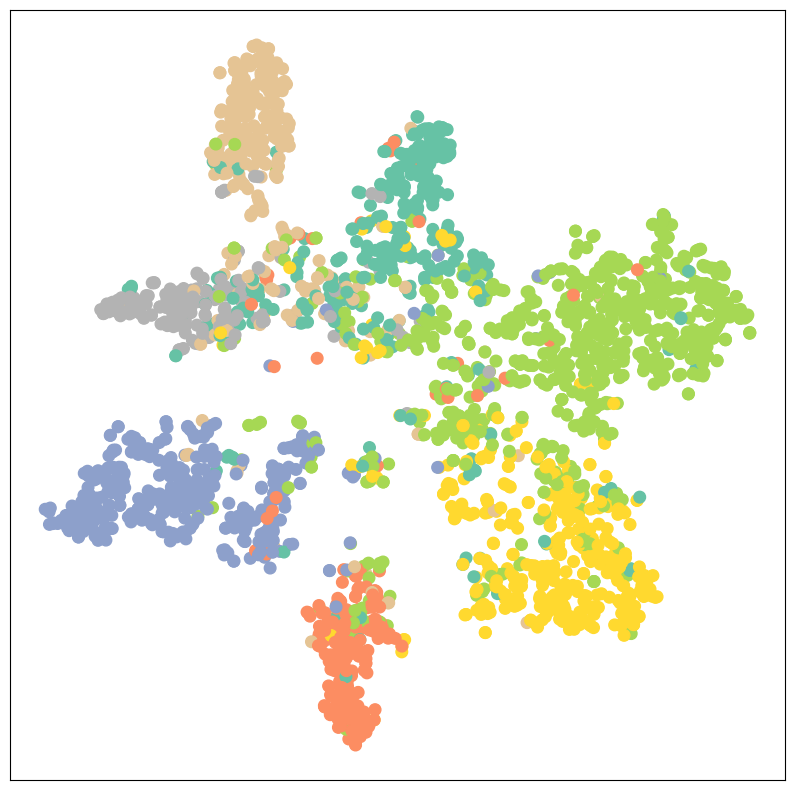

In [18]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

# Обучение GAT

Для изучения как себя поведёт механизм attention заменим слои GCNConv на GATConv. 

In [26]:
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=heads) 
        self.conv2 = GATConv(hidden_channels * heads, dataset.num_classes, heads=heads)  

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc


for epoch in range(1, 201):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=8)
)
Epoch: 001, Loss: 4.0201, Val: 0.3600, Test: 0.3750
Epoch: 002, Loss: 3.7588, Val: 0.5100, Test: 0.5610
Epoch: 003, Loss: 3.4572, Val: 0.5780, Test: 0.6340
Epoch: 004, Loss: 3.1861, Val: 0.6220, Test: 0.6710
Epoch: 005, Loss: 2.8601, Val: 0.6500, Test: 0.6870
Epoch: 006, Loss: 2.5357, Val: 0.6620, Test: 0.7000
Epoch: 007, Loss: 2.3246, Val: 0.6680, Test: 0.7090
Epoch: 008, Loss: 1.9173, Val: 0.6780, Test: 0.7160
Epoch: 009, Loss: 1.6623, Val: 0.6880, Test: 0.7260
Epoch: 010, Loss: 1.4089, Val: 0.7120, Test: 0.7390
Epoch: 011, Loss: 1.2722, Val: 0.7300, Test: 0.7520
Epoch: 012, Loss: 1.1217, Val: 0.7620, Test: 0.7650
Epoch: 013, Loss: 1.0142, Val: 0.7780, Test: 0.7740
Epoch: 014, Loss: 0.8545, Val: 0.7800, Test: 0.7800
Epoch: 015, Loss: 0.7735, Val: 0.7780, Test: 0.7930
Epoch: 016, Loss: 0.7231, Val: 0.7800, Test: 0.7920
Epoch: 017, Loss: 0.6419, Val: 0.7800, Test: 0.7940
Epoch: 018, Loss: 0.5653, Val: 0.7780

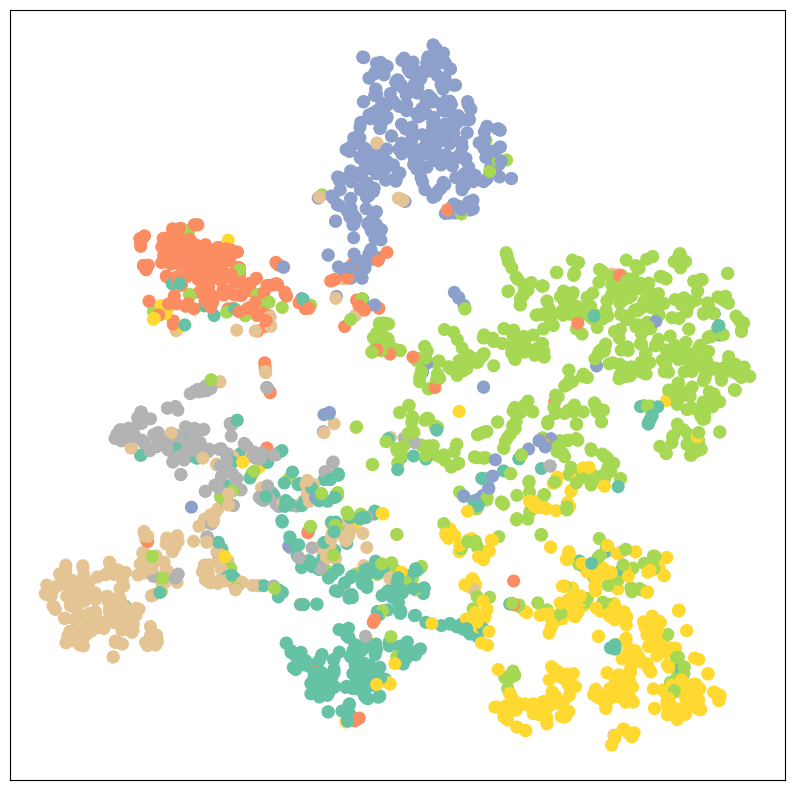

In [27]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)